In [1]:
using SparseArrays, LinearAlgebra

function readgraph(graph)
    I=Int[]
    J=Int[]
    open(graph) do f
        linecounter = 0
        for l in eachline(f)
            linecounter += 1
            v = split(l)
            if v[1] == "D"
                i,j = extrema((parse(Int, v[2])+1, parse(Int, v[3])+1))
                push!(I, i)
                push!(J, j)
            end
        end
    end
    N = maximum(I)
    H = sparse(J.-N,I,fill(1,length(I))) .÷ 2
end


function readseeds(seeds, H)
    M, N = size(H)
    @show size(H)
    v = Int[]
    open(seeds) do f
        for l in eachline(f)
            if l[1] != '#'
                v = parse.(Int, split(l)) .- N .+ 1
            end
        end
        println("$(length(v)) removed factors $v")
        return H[setdiff(1:size(H,1), v), :]
    end
end

readseeds (generic function with 1 method)

In [2]:
function leaf_removal(H::SparseMatrixCSC)
    M, N = size(H)
    Ht = sparse(transpose(H)) # for faster access by row
    degs = vec(sum(H .!= 0, dims=1))
    facts = fill(true, M)
    rowperm = Int[]
    Q = findall(degs .== 1)
    indep = findall(degs .== 0)
    dep = Int[]
    while !isempty(Q)
        i = popfirst!(Q)
        degs[i] == 0 && continue
        push!(dep, i)
        ∂i = rowvals(H)[nzrange(H,i)]
        ∂i = ∂i[facts[∂i]]
        @assert length(∂i) == 1 # should be a residual leaf
        a = ∂i[1]
        facts[a] = false
        push!(rowperm, a) 
        for j in rowvals(Ht)[nzrange(Ht,a)]
            degs[j] -= 1
            if j != i
                if degs[j] == 0
                    push!(indep, j)
                elseif degs[j] == 1
                    push!(Q, j)
                end
            end
        end
    end
    all(degs .==  0) || @warn "non-empty core"
    rowperm, [dep; indep]
end

leaf_removal (generic function with 1 method)

In [3]:
isuppertriang(H::SparseMatrixCSC) = all(rowvals(H)[last(nzrange(H,i))] == i for i = 1:size(H,1))

function ut2diagGF2!(T::SparseMatrixCSC)
    (m,n) = size(T)
    # Check that the left part of T is unit upper triangular
    @assert isuppertriang(T)
    # Loop over diagonal elements
    for c in m:-1:2
        # Find non-zero elements above T[c,c] and perform row operations to 
        #  cancel them out
        for (j,v) in @views zip(rowvals(T[:,c]),nonzeros(T[:,c]))
            if v != 0 && j < c
                for k in rowvals(T[c,c:end]).+c.-1
                    T[j,k] ⊻= T[c,k]
                end
            end
        end
    end
    dropzeros!(T)
end

ut2diagGF2! (generic function with 1 method)

In [4]:
function findbasis(H)
    rowperm, colperm = leaf_removal(H)
    Hnew = H[rowperm, colperm]
    ut2diagGF2!(Hnew)
    B = [Hnew[:, size(Hnew, 1)+1:end]; I]
    indep = colperm[size(H,1)+1:end]
    B[invperm(colperm),:], indep
end 

findbasis (generic function with 1 method)

In [141]:
H = readgraph("/home/ab/src/spread/graphN9000.txt")
H = readseeds("/home/ab/src/spread/seedsN9000.txt", H)
B, indep = findbasis(H);
M,N = size(H)
@show R=1-M/N

size(H) = (6600, 9000)
5 removed factors [129, 1515, 1531, 1655, 3471]
R = 1 - M / N = 0.26722222222222225


0.26722222222222225

In [142]:
rowperm,colperm = leaf_removal(H)

([4568, 97, 303, 4962, 589, 3783, 2642, 554, 3162, 1042  …  1081, 4040, 5522, 198, 5901, 3075, 7, 3606, 4236, 3265], [91, 353, 364, 685, 3356, 3896, 4261, 4784, 4976, 5077  …  5628, 7363, 4170, 8751, 4673, 5935, 798, 7435, 4491, 8359])

In [143]:
H[rowperm, colperm]

6595×9000 SparseMatrixCSC{Int64, Int64} with 19783 stored entries:
⠙⢮⣖⣂⡇⡐⠂⣆⢥⣰⣤⣚⡴⠗⢭⢰⣝⠰⣷⠢⡩⣓⣂⢎⢓⡧⣵⢷⡆⣿⢍⡦⣘⣀⣧⢄⡲⢦⡲⠐
⠀⠀⠙⢿⡿⣝⢲⢮⢮⣧⢛⣮⡧⡷⣽⡀⡡⠮⡒⠮⣜⣓⠛⡹⡿⠕⢯⢭⠳⣿⡐⣡⡾⠟⠯⢓⢈⡢⠽⢆
⠀⠀⠀⠀⠙⢮⡙⢿⣻⠕⢙⣼⠪⣨⡞⡙⣴⡳⣹⡻⡢⡾⢚⢁⡵⡿⢸⡗⢫⣧⠶⡅⠏⣇⡦⣌⠳⠹⠐⣨
⠀⠀⠀⠀⠀⠀⠙⢦⡈⠛⢯⣧⠫⠹⢳⡻⢏⣓⠴⣋⣼⣗⣤⣶⡘⢧⣩⡭⠾⣿⢊⠹⣽⡻⠆⢣⠹⠦⡶⣔
⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠈⠻⢷⡗⣟⣆⡓⣧⢵⡓⣎⠋⡬⣭⡰⡥⡥⣼⣹⣷⠐⢘⣫⣟⡊⣰⣃⠿⡁
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠙⠿⣮⠽⡿⠼⢌⢈⣇⡓⢹⡻⣷⠹⡻⠺⣿⡵⣫⣗⣣⡱⡳⢧⢑⡇
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠈⠳⣕⣹⣵⣍⠹⣨⢷⢱⡀⣣⠧⠀⣿⣿⣯⠵⣡⣾⡵⢔⠷⡶
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠙⢮⣾⣻⠙⡾⣶⢧⡮⣨⡂⠸⣿⣿⣹⣋⣯⣻⣍⣨⠽
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠙⢷⡜⣩⠆⡹⡼⠆⠀⠀⢿⣿⣧⡳⣵⡬⢍⠍⡛
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠙⢶⡯⠿⣺⣐⡁⠀⠈⣿⣿⣿⣻⠗⠶⣽⠭
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠀⠹⣧⡻⠷⠂⠀⠀⠘⣿⣿⣿⣧⣏⡦⢟
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠀⠈⢷⢗⡀⠀⠀⠀⠘⢿⣿⣿⣮⢷⡟
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡀⠈⢧⠀⠀⠀⠀⠀⠈⠻⣿⣿⣿⠋
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⢦⡘⡇⠀⠀⠀⠀⠀⠀⠘⠿⣿⣿
⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠀⠙⠃⠀⠀⠀⠀⠀⠀⠀⠀⠈⠛

In [74]:
include("../code/sp.jl")
include("../code/matrix_generator.jl")
include("../code/slim_graphs.jl")
include("../code/bp.jl")

plot_rdb (generic function with 1 method)

In [55]:
using StaticArrays, OffsetArrays, Statistics
f1 = 0.01
f3 = 0.4
Λ = OffsetVector([0,f1,1-f1-f3,f3], 0:3)
K = OffsetVector([0,0,0,1], 0:3)
mK = sum(k*K[k] for k=eachindex(K))
mΛ = sum(d*Λ[d] for d=eachindex(Λ))
α = mΛ/mK
R=1-α
# Single instance
n = 100*3*7*2
nedges = Int(round(n*sum(i*l for (i,l) in pairs(Λ)), digits=8))
m = Int(nedges/3)
Ht = ldpc_matrix(n, m, nedges, Λ, K)
H = permutedims(Ht)
x0 = rand((0,1), size(H,2))
s = (-1).^x0
J = 20
init=OffsetArray(MVector{2J+1}(fill(1/(2J+1),2J+1)), -J:J)
sp = survey_propagation(H; field=s, init, y=0.5);

In [56]:
B,indep = findbasis(H, Ht);

In [57]:
using ProgressMeter

callback(t, ε, sp) = (println("$t $ε"); false)

function decimate!(sp; decsteps=10)
    H = sp.H
    freevars = copy(indep)
    iteration!(sp, maxiter=700, tol=1e-5, callback=callback, damp=0.5)
    while !isempty(freevars)
        iteration!(sp, maxiter=100, tol=1e-3, damp=0.5)
        mag = map(p->p'eachindex(p), sp.survey)
        sort!(freevars, by=i->abs(mag[i]))
        freevars, tofix = freevars[1:end-decsteps], freevars[max(1,end-decsteps+1):end]
        println("fixing: $tofix")
        sp.efield[tofix] .= sp.J.*sign.(mag[tofix])
        x = Vector(mag .< 0)
        x1 = (B*x[indep]) .% 2
        println("$(sum(H*x .%2)) $(sum(x .!= x0)/length(x)) $(sum(x1 .!= x0)/length(x)) $(length(freevars)/length(indep))")
    end
end

decimate!(sp; decsteps=1)

1 0.975609756097561
2 0.4878048780487805
3 0.4878048780487803
4 0.36585365853658547
5 0.3172922166991863
6 0.2773366211103645
7 0.2741901578362137
8 0.24246694635771193
9 0.19743306213667144
10 0.18325279450208948
11 0.16614905030521032
12 0.14226550863138754
13 0.12562443057687933
14 0.12002766012811084
15 0.10997228502393624
16 0.09764511465117454
17 0.09487910246147713
18 0.08856223531549973
19 0.07988242043709093
20 0.0723732757175663
21 0.06916610710328286
22 0.06792453724072472
23 0.06699285206398009
24 0.0644241284840546
25 0.06055887009224281
26 0.05722990689308316
27 0.05510492092518171
28 0.051933846374852544
29 0.04798693317696928
30 0.04353386754582894
31 0.03882144281424843
32 0.03405997543170136
33 0.029417254325340203
34 0.025018173537052713
35 0.02442484384676391
36 0.02404369664177669
37 0.02341652440769637
38 0.022587913221735034
39 0.02160718813207463
40 0.02052433438188206
41 0.019386635864307444
42 0.018236232883086678
43 0.017108623466311756
44 0.0160790173789363


335 0.0003407162474226011
336 0.00033025246027107436
337 0.0003201057320353362
338 0.00031026672610812156
339 0.0003007263622595291
340 0.00029147581095956276
341 0.00028250648771321885
342 0.0002738100474248828
343 0.00026537837879592185
344 0.0002572035987720156
345 0.0002492780470406686
346 0.0002415942805928939
347 0.00023414506834784632
348 0.0002269233858535058
349 0.00021992241006241198
350 0.00021313551418766785
351 0.00020655626264554083
352 0.00020017840608133053
353 0.00019399587648838423
354 0.00018800278241493107
355 0.000182193404264952
356 0.0001765621896920866
357 0.00017110374908779757
358 0.00016581285116357147
359 0.00016068441862859828
360 0.00015571352396082094
361 0.00015089538527413016
362 0.00014622536227748562
363 0.00014169895232851726
364 0.0001373117865801632
365 0.00013305962621612544
366 0.0001289383587806947
367 0.00012494399459495042
368 0.00012107266326322197
369 0.00011732061026570317
370 0.00011368419363722015
371 0.00011015988073104221
372 0.00010674

fixing: Int32[2197]
515 0.15071428571428572 0.3726190476190476 0.9156908665105387
fixing: Int32[281]
512 0.15095238095238095 0.37761904761904763 0.914519906323185
fixing: Int32[3005]
511 0.15119047619047618 0.3761904761904762 0.9133489461358314
fixing: Int32[180]
515 0.15119047619047618 0.3761904761904762 0.9121779859484778
fixing: Int32[1367]
516 0.15119047619047618 0.3761904761904762 0.9110070257611241
fixing: Int32[464]
513 0.15166666666666667 0.37785714285714284 0.9098360655737705
fixing: Int32[1938]
511 0.1519047619047619 0.37785714285714284 0.9086651053864169
fixing: Int32[199]
508 0.15214285714285714 0.37714285714285717 0.9074941451990632
fixing: Int32[4002]
508 0.1523809523809524 0.37714285714285717 0.9063231850117096
fixing: Int32[25]
506 0.15285714285714286 0.37761904761904763 0.905152224824356
fixing: Int32[1888]
511 0.1523809523809524 0.37833333333333335 0.9039812646370023
fixing: Int32[4102]
510 0.15261904761904763 0.379047619047619 0.9028103044496487
fixing: Int32[247]
50

fixing: Int32[1384]
482 0.15714285714285714 0.3711904761904762 0.7962529274004684
fixing: Int32[4139]
482 0.15714285714285714 0.3711904761904762 0.7950819672131147
fixing: Int32[3137]
482 0.15714285714285714 0.3711904761904762 0.7939110070257611
fixing: Int32[1259]
483 0.1569047619047619 0.3707142857142857 0.7927400468384075
fixing: Int32[3389]
480 0.15714285714285714 0.3707142857142857 0.7915690866510539
fixing: Int32[3707]
482 0.15714285714285714 0.36976190476190474 0.7903981264637002
fixing: Int32[523]
486 0.1569047619047619 0.3711904761904762 0.7892271662763466
fixing: Int32[3301]
485 0.1569047619047619 0.36976190476190474 0.788056206088993
fixing: Int32[1244]
478 0.1569047619047619 0.370952380952381 0.7868852459016393
fixing: Int32[520]
475 0.15738095238095237 0.370952380952381 0.7857142857142857
fixing: Int32[3404]
478 0.15738095238095237 0.3742857142857143 0.7845433255269321
fixing: Int32[1226]
478 0.15738095238095237 0.3742857142857143 0.7833723653395784
fixing: Int32[192]
475 

fixing: Int32[1959]
443 0.16523809523809524 0.35333333333333333 0.6768149882903981
fixing: Int32[709]
443 0.16523809523809524 0.35333333333333333 0.6756440281030445
fixing: Int32[3619]
443 0.16547619047619047 0.35333333333333333 0.6744730679156908
fixing: Int32[2192]
443 0.1657142857142857 0.3530952380952381 0.6733021077283372
fixing: Int32[4049]
443 0.1657142857142857 0.3504761904761905 0.6721311475409836
fixing: Int32[542]
444 0.16595238095238096 0.3469047619047619 0.6709601873536299
fixing: Int32[4096]
435 0.1680952380952381 0.36404761904761906 0.6697892271662763
fixing: Int32[1400]
438 0.16785714285714284 0.36404761904761906 0.6686182669789227
fixing: Int32[4082]
435 0.1680952380952381 0.35119047619047616 0.667447306791569
fixing: Int32[3649]
437 0.16857142857142857 0.35523809523809524 0.6662763466042154
fixing: Int32[566]
439 0.16833333333333333 0.36047619047619045 0.6651053864168618
fixing: Int32[3041]
434 0.16904761904761906 0.3495238095238095 0.6639344262295082
fixing: Int32[29

fixing: Int32[3]
419 0.17523809523809525 0.3445238095238095 0.5573770491803278
fixing: Int32[1720]
416 0.1761904761904762 0.34833333333333333 0.5562060889929742
fixing: Int32[1477]
416 0.17642857142857143 0.35 0.5550351288056206
fixing: Int32[1443]
414 0.17666666666666667 0.35 0.5538641686182669
fixing: Int32[956]
414 0.1769047619047619 0.35404761904761906 0.5526932084309133
fixing: Int32[3383]
405 0.17761904761904762 0.35404761904761906 0.5515222482435597
fixing: Int32[2416]
405 0.17761904761904762 0.35404761904761906 0.550351288056206
fixing: Int32[1732]
405 0.17761904761904762 0.35404761904761906 0.5491803278688525
fixing: Int32[1667]
401 0.17833333333333334 0.3514285714285714 0.5480093676814989
fixing: Int32[472]
400 0.17809523809523808 0.34809523809523807 0.5468384074941453
fixing: Int32[3018]
400 0.17809523809523808 0.34809523809523807 0.5456674473067916
fixing: Int32[4023]
402 0.17785714285714285 0.35214285714285715 0.544496487119438
fixing: Int32[994]
400 0.17785714285714285 0.

fixing: Int32[1752]
270 0.20023809523809524 0.32071428571428573 0.4379391100702576
fixing: Int32[424]
269 0.20047619047619047 0.32071428571428573 0.43676814988290397
fixing: Int32[2907]
270 0.20047619047619047 0.32071428571428573 0.43559718969555034
fixing: Int32[3180]
270 0.2007142857142857 0.32404761904761903 0.4344262295081967
fixing: Int32[160]
272 0.2 0.32261904761904764 0.4332552693208431
fixing: Int32[3381]
272 0.20047619047619047 0.32261904761904764 0.43208430913348944
fixing: Int32[1342]
274 0.20095238095238097 0.32285714285714284 0.4309133489461358
fixing: Int32[3140]
274 0.20095238095238097 0.32285714285714284 0.4297423887587822
fixing: Int32[3382]
272 0.2011904761904762 0.32285714285714284 0.42857142857142855
fixing: Int32[3928]
271 0.2011904761904762 0.3261904761904762 0.4274004683840749
fixing: Int32[2710]
271 0.2011904761904762 0.3261904761904762 0.4262295081967213
fixing: Int32[790]
271 0.2011904761904762 0.3261904761904762 0.42505854800936765
fixing: Int32[3247]
270 0.

fixing: Int32[2072]
121 0.22738095238095238 0.2978571428571429 0.319672131147541
fixing: Int32[650]
119 0.22738095238095238 0.2978571428571429 0.3185011709601874
fixing: Int32[586]
117 0.2276190476190476 0.2978571428571429 0.31733021077283374
fixing: Int32[1597]
117 0.2276190476190476 0.2978571428571429 0.3161592505854801
fixing: Int32[163]
121 0.2276190476190476 0.2995238095238095 0.3149882903981265
fixing: Int32[1247]
119 0.22833333333333333 0.30642857142857144 0.31381733021077285
fixing: Int32[2703]
121 0.22785714285714287 0.2978571428571429 0.3126463700234192
fixing: Int32[1616]
122 0.2276190476190476 0.3007142857142857 0.3114754098360656
fixing: Int32[3096]
121 0.22785714285714287 0.3007142857142857 0.31030444964871196
fixing: Int32[3543]
117 0.22857142857142856 0.3061904761904762 0.3091334894613583
fixing: Int32[45]
115 0.22904761904761906 0.30904761904761907 0.3079625292740047
fixing: Int32[138]
114 0.2292857142857143 0.3016666666666667 0.30679156908665106
fixing: Int32[2994]
11

fixing: Int32[892]
72 0.23857142857142857 0.2966666666666667 0.20140515222482436
fixing: Int32[696]
64 0.23976190476190476 0.2938095238095238 0.20023419203747073
fixing: Int32[993]
59 0.24 0.2869047619047619 0.1990632318501171
fixing: Int32[2429]
58 0.24071428571428571 0.2835714285714286 0.19789227166276346
fixing: Int32[136]
60 0.23976190476190476 0.2916666666666667 0.19672131147540983
fixing: Int32[540]
67 0.23904761904761904 0.2938095238095238 0.1955503512880562
fixing: Int32[2113]
54 0.24166666666666667 0.28476190476190477 0.19437939110070257
fixing: Int32[2228]
58 0.24119047619047618 0.29119047619047617 0.19320843091334894
fixing: Int32[2206]
66 0.2392857142857143 0.2904761904761905 0.1920374707259953
fixing: Int32[2804]
56 0.24119047619047618 0.29119047619047617 0.19086651053864168
fixing: Int32[389]
60 0.24166666666666667 0.2914285714285714 0.18969555035128804
fixing: Int32[1767]
73 0.23761904761904762 0.29738095238095236 0.1885245901639344
fixing: Int32[3122]
56 0.2426190476190

fixing: Int32[1]
32 0.25285714285714284 0.2814285714285714 0.08196721311475409
fixing: Int32[1258]
22 0.25357142857142856 0.2842857142857143 0.08079625292740047
fixing: Int32[3302]
19 0.2542857142857143 0.2842857142857143 0.07962529274004684
fixing: Int32[127]
30 0.25357142857142856 0.2869047619047619 0.07845433255269321
fixing: Int32[2119]
29 0.2538095238095238 0.2811904761904762 0.07728337236533958
fixing: Int32[1272]
19 0.2542857142857143 0.2835714285714286 0.07611241217798595
fixing: Int32[469]
22 0.25476190476190474 0.28285714285714286 0.07494145199063232
fixing: Int32[1862]
39 0.25523809523809526 0.2838095238095238 0.07377049180327869
fixing: Int32[2659]
12 0.25523809523809526 0.28404761904761905 0.07259953161592506
fixing: Int32[1167]
46 0.25261904761904763 0.2845238095238095 0.07142857142857142
fixing: Int32[2067]
43 0.25357142857142856 0.27904761904761904 0.0702576112412178
fixing: Int32[493]
19 0.25523809523809526 0.28523809523809524 0.06908665105386416
fixing: Int32[2808]
32

In [71]:
mag = sign.(map(p->p'eachindex(p), sp.survey))
x = mag .== -1
w = sparse(B*x[indep] .% 2);

In [73]:
dist = mean(w .!= x0)
R = 1-m/n
R, dist

(0.20333333333333337, 0.2652380952380952)

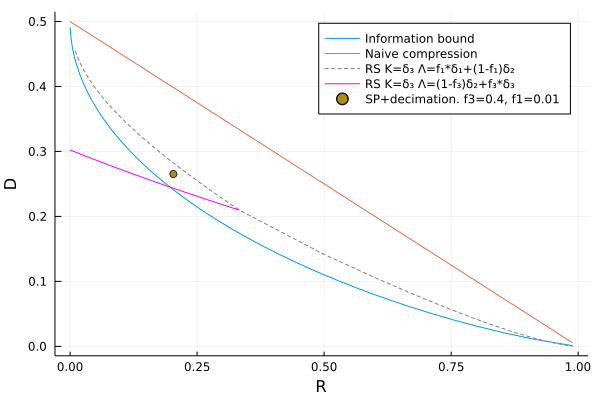

In [77]:
plot_rdb()
scatter!([R], [dist], label="SP+decimation. f3=$f3, f1=$f1")

In [219]:
function callback(t, ε, sp)
    t % 10 != 0 && return false
    mag = map(p->p'sign.(eachindex(p)), sp.survey)
    x = Vector(mag .< 0)
    x1 = (B*x[indep]) .% 2
    check = sum(H*x .%2)
    println("$t $check $(sum(x .!= x0)/length(x)) $(sum(x1 .!= x0)/length(x))")
    return check == 0
end
iteration!(sp, maxiter=100000, tol=1e-5, damp=0.2, rein=0.1, callback=callback)

10 281 0.202 0.2833333333333333
20 262 0.20477777777777778 0.27844444444444444
30 236 0.20666666666666667 0.2713333333333333
40 239 0.207 0.27444444444444444
50 215 0.20966666666666667 0.27155555555555555
60 207 0.21 0.27044444444444443
70 199 0.21166666666666667 0.2728888888888889
80 188 0.21244444444444444 0.2693333333333333
90 167 0.21266666666666667 0.27055555555555555
100 170 0.21222222222222223 0.27255555555555555
110 165 0.2127777777777778 0.2688888888888889
120 160 0.2137777777777778 0.2703333333333333
130 142 0.21555555555555556 0.26944444444444443
140 140 0.21544444444444444 0.2653333333333333
150 133 0.21644444444444444 0.2657777777777778
160 133 0.21755555555555556 0.2598888888888889
170 111 0.219 0.259
180 97 0.22022222222222224 0.25733333333333336
190 77 0.2212222222222222 0.25266666666666665
200 77 0.22155555555555556 0.24988888888888888
210 62 0.22233333333333333 0.247
220 73 0.222 0.24855555555555556
230 72 0.22211111111111112 0.2511111111111111
240 67 0.223 0.25111111

In [206]:
mag = map(p->p'eachindex(p), sp.survey);
x = Vector(mag .< 0)
xbase = B*(x[indep]) .% 2;

In [207]:
all(sign.(mag[indep]) == sign.(sp.efield[indep])) 

false

In [208]:
@show sum(x .!= x0)/length(xbase) 
@show sum(H*x .% 2)
@show sum(xbase .!= x0)/length(xbase)
@show sum(H*xbase .%2)/size(H,1)

sum(x .!= x0) / length(xbase) = 0.2058888888888889
sum((H * x) .% 2) = 235
sum(xbase .!= x0) / length(xbase) = 0.26766666666666666
sum((H * xbase) .% 2) / size(H, 1) = 0.0


0.0

In [209]:
sum(p[begin] for p in sp.survey)

2.2417460331495522e-69

In [128]:
[p[[-sp.J,sp.J]] for p in sp.survey[indep]]

2405-element Vector{Vector{Float64}}:
 [0.0, 1.0]
 [0.0, 1.0]
 [0.0, 1.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [0.0, 1.0]
 [0.0, 1.0]
 [1.0, 0.0]
 [0.0, 1.0]
 [1.0, 0.0]
 [1.0, 0.0]
 [0.0, 1.0]
 ⋮
 [1.0, 0.0]
 [0.0, 1.0]
 [1.0, 0.0]
 [0.0, 1.0]
 [0.0, 1.0]
 [1.0, 0.0]
 [0.0, 1.0]
 [0.0, 1.0]
 [0.0, 1.0]
 [0.0, 1.0]
 [1.0, 0.0]
 [0.0, 1.0]

In [124]:
[(1,2)...]

2-element Vector{Int64}:
 1
 2

In [27]:
using ProgressMeter
callback(t,fg) = nothing;#println("$t $(fg.belief[1:4])")

nsamples = 10
fg = maxsum(H,  1 .- 2y .+ 1e-8*randn(N));

# the mapping is (0,1)=>(1,-1)
dist = map(1:nsamples) do i
    y = rand((0,1), N)
    fg.M .= 0
    fg.efield .= 1 .- 2y .+ 1e-8*randn(N)
    iteration!(fg; maxiter=2000, γ=1e-3, callback=callback)
    x = Int.(fg.belief .< 0)
    c = sum(fg.H'x .% 2)
    d = sum(x .⊻ y)/N
    @show d c
    x1 = B*x[indep] .% 2; d1 = sum(x1 .⊻ y)/N; c1 = sum(fg.H'x1 .% 2); @show d1 c1 
    d1
end
sum(dist)/nsamples

LoadError: UndefVarError: y not defined

In [28]:
1-M/N,sum(dist)/nsamples

LoadError: UndefVarError: dist not defined

In [29]:
x=[1:10;]; f=(x .% 2 .== 1);x[findall(f)]==x[f]

true

In [52]:
dist = map(1:10) do i
    Random.seed!(i)
    
    y = rand((0,1), N)

    lm = LossyModelGF2(fg, zeros(N), Inf, 1.0, y)
    
    function checker()
        v = (B*((fg.fields .< 0)[indep])) .% 2;
        dist = sum(v .⊻ y)/N
        check = sum(H*(fg.fields .< 0) .% 2)
        check, dist
    end

    independent = falses(N)
    independent[indep] .= true
    res_fg = solve!(lm, fg, randseed=1, verbose=true, showprogress=true, 
        independent=independent, basis = B)
#    res_fg = solve!(lm, fg, randseed=1, verbose=true, showprogress=true)
    avg_dist = res_fg.distortion 
    check, dist = checker()
    @show dist check avg_dist
    dist
end

Trial 1/1 100%|█████████████████████████████████████████| Time: 0:00:01


dist = 0.24287749287749288
check = 1
avg_dist = 0.4309116809116809


Trial 1/1 100%|█████████████████████████████████████████| Time: 0:00:01


dist = 0.24786324786324787
check = 1
avg_dist = 0.4309116809116809


Trial 1/1 100%|█████████████████████████████████████████| Time: 0:00:01


dist = 0.25427350427350426
check = 1
avg_dist = 0.4537037037037037


Trial 1/1 100%|█████████████████████████████████████████| Time: 0:00:01


dist = 0.26495726495726496
check = 5
avg_dist = 0.4565527065527066


Trial 1/1 100%|█████████████████████████████████████████| Time: 0:00:01


dist = 0.2378917378917379
check = 1
avg_dist = 0.42592592592592593


Trial 1/1 100%|█████████████████████████████████████████| Time: 0:00:01


dist = 0.26851851851851855
check = 4
avg_dist = 0.4423076923076923


Trial 1/1 100%|█████████████████████████████████████████| Time: 0:00:01


dist = 0.245014245014245
check = 6
avg_dist = 0.4458689458689459
dist = 0.24715099715099714
check = 0
avg_dist = 0.24715099715099714


Trial 1/1 100%|█████████████████████████████████████████| Time: 0:00:01


dist = 0.25427350427350426
check = 2
avg_dist = 0.44515669515669515
dist = 0.24857549857549857
check = 0
avg_dist = 0.24857549857549857


10-element Vector{Float64}:
 0.24287749287749288
 0.24786324786324787
 0.25427350427350426
 0.26495726495726496
 0.2378917378917379
 0.26851851851851855
 0.245014245014245
 0.24715099715099714
 0.25427350427350426
 0.24857549857549857

In [53]:
dev = sqrt(sum(dist.^2)/length(dist)-(sum(dist)/length(dist))^2)/sqrt(length(dist))
1-M/N, sum(dist)/length(dist)

(0.24002849002849003, 0.2511396011396011)